# Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ovm.monetary.model import MonetaryModel

import logging
import os
import random
import typing as tp

import line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
# %matplotlib widget
from mesa.datacollection import DataCollector
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule
import numpy as np
import pandas as pd
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from tqdm import tqdm

from ovm.monetary.agents import (
    MonetaryAgent, 
    MonetaryArbitrageur, 
    MonetaryKeeper, 
    MonetaryLiquidator, 
    MonetarySniper
)

from ovm.monetary.markets import MonetaryFMarket
from ovm.monetary.model import MonetaryModel
from ovm.monetary.data_collection import DataCollectionOptions
from ovm.monetary.plot_labels import (
    price_deviation_label,
    spot_price_label,
    futures_price_label,
    skew_label,
    inventory_wealth_ovl_label,
    inventory_wealth_usd_label,
    GINI_LABEL,
    GINI_ARBITRAGEURS_LABEL,
    SUPPLY_LABEL,
    TREASURY_LABEL,
    LIQUIDITY_LABEL, 
)

from ovm.monetary.plots import (
    DEFAULT_FIGURE_SIZE, 
    convert_time_in_seconds_to_index, 
    convert_time_interval_in_seconds_to_indices, 
    construct_full_time_axis, 
    construct_time_axis, 
    get_indices_and_time_axis_to_plot, 
    plot_multiple_variables_over_time, 
    plot_price_deviations, 
    plot_skews, 
    plot_single_variable_over_time, 
    plot_single_variable_over_time_from_numpy_array, 
    plot_supply, 
    plot_treasury, 
    plot_liquidity, 
    plot_spot_vs_futures_price, 
    plot_open_positions
)

from ovm.monetary.reporters import * 
from ovm.monetary.data_io import (
    construct_sims_map, 
    construct_ticker_to_series_of_prices_map_from_simulated_prices, 
    construct_ticker_to_series_of_prices_map_from_historical_prices, 
    load_and_construct_ticker_to_series_of_prices_map_from_historical_prices
)

from ovm.paths import (
    HistoricalDataSource, 
    construct_historical_data_directory
)

from ovm.simulation.bootstrap import plot_multivariate_simulation
from ovm.simulation.resampling import (
    load_log_returns,
    simulate_new_price_series_via_bootstrap,
    store_simulated_price_series_in_output_directory
)

from ovm.tickers import (
    ETH_USD_TICKER,
    COMP_USD_TICKER,
    LINK_USD_TICKER,
    YFI_USD_TICKER,
    EOS_ETH_TICKER,
    MKR_ETH_TICKER,
    SNX_ETH_TICKER,
    TRX_ETH_TICKER,
    XRP_ETH_TICKER,
    ETH_TICKER,
    USD_TICKER,
    get_ovl_quote_ticker,
)

from ovm.time_resolution import (
    TimeResolution, 
    TimeScale
)

environment variable OVERLAY_MONETARY_INPUT_BASE_PATH not set defaulting to /home/michael/PycharmProjects/overlay-monetary
environment variable OVERLAY_MONETARY_INPUT_BASE_PATH not set defaulting to /home/michael/PycharmProjects/overlay-monetary


In [3]:
logger = logging.getLogger(__name__)
logger.level

0

In [4]:
logging.getLevelName(logging.root.level)

'WARNING'

In [5]:
logging.root.level

30

In [6]:
%load_ext line_profiler

# Set Parameters

In [7]:
time_resolution = TimeResolution.ONE_MINUTE

# # run agent based simulations for 24 hours
# number_of_steps_to_simulate = \
#     time_resolution.convert_time_in_days_to_number_of_steps(1.0)

# run agent based simulations for 7 days
number_of_steps_to_simulate = \
    time_resolution.convert_time_in_days_to_number_of_steps(7.0)

# # run agent based simulations for 2 years
# number_of_steps_to_simulate = \
#     time_resolution.convert_time_in_years_to_number_of_steps(2.0)

print(f'number_of_steps_to_simulate={number_of_steps_to_simulate}')
historical_data_source = HistoricalDataSource.KUCOIN

directory_path = \
    construct_historical_data_directory(
        historical_data_source=historical_data_source, 
        time_resolution=time_resolution)

numpy_seed = 42

tickers = [EOS_ETH_TICKER,
           MKR_ETH_TICKER,
           SNX_ETH_TICKER,
           XRP_ETH_TICKER]

ovl_ticker = SNX_ETH_TICKER  # for sim source, since OVL doesn't actually exist yet
quote_ticker = ETH_TICKER
ovl_quote_ticker = get_ovl_quote_ticker(quote_ticker)


tickers_with_ovl = [ovl_quote_ticker if ticker == ovl_ticker else ticker for ticker in tickers]
tickers_with_ovl

number_of_steps_to_simulate=10080


['EOS-ETH', 'MKR-ETH', 'OVL-ETH', 'XRP-ETH']

# Load Historical Price Data and Resample

In [8]:
log_return_df, closing_price_df, initial_prices = \
    load_log_returns(series_names=tickers,
                     period_length_in_seconds=time_resolution.in_seconds,
                     directory_path=directory_path)
log_return_df.shape

(1013821, 4)

In [9]:
simulated_sample_length_in_seconds = \
    5 * 365.25 * 24 * 60 * 60

# simulated_sample_length_in_seconds = log_return_df.shape[0] * time_resolution.in_seconds
np.random.seed(numpy_seed)

simulated_prices = \
    simulate_new_price_series_via_bootstrap(
        initial_prices=initial_prices,
        input_log_return_df=log_return_df,
        time_resolution=time_resolution,
        block_length_in_seconds=4 * 24 * 60 * 60,  # 4 day block length
        simulated_sample_length_in_steps_in_seconds=simulated_sample_length_in_seconds,
            number_of_paths=1)
simulated_prices.shape

(1, 2629800, 4)

In [10]:
simulated_cumulative_returns = simulated_prices / simulated_prices[0, 0, :] - 1.0

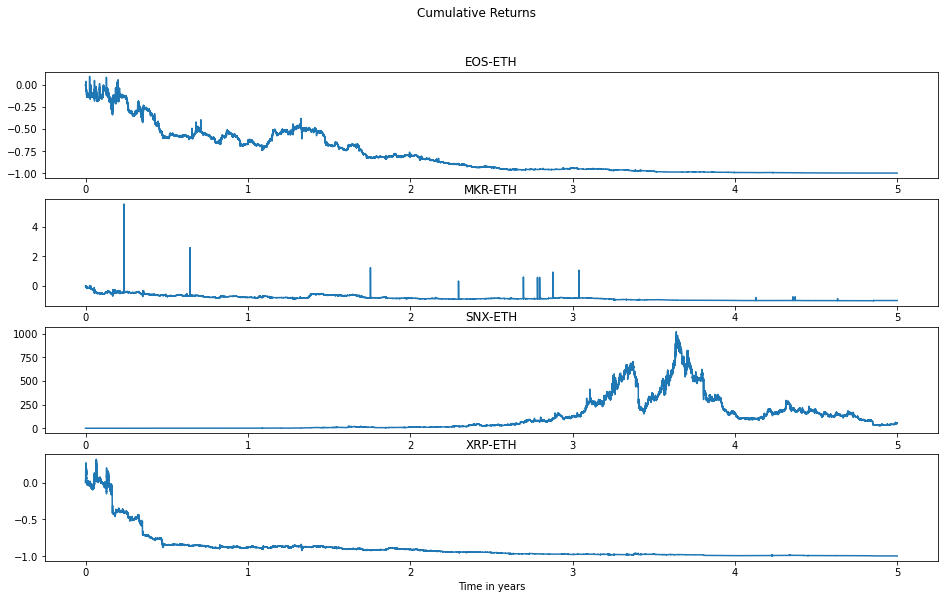

In [11]:
plot_multivariate_simulation(simulated_data=simulated_cumulative_returns,
                             series_names=tickers, 
                             time_resolution=time_resolution, 
                             title='Cumulative Returns')

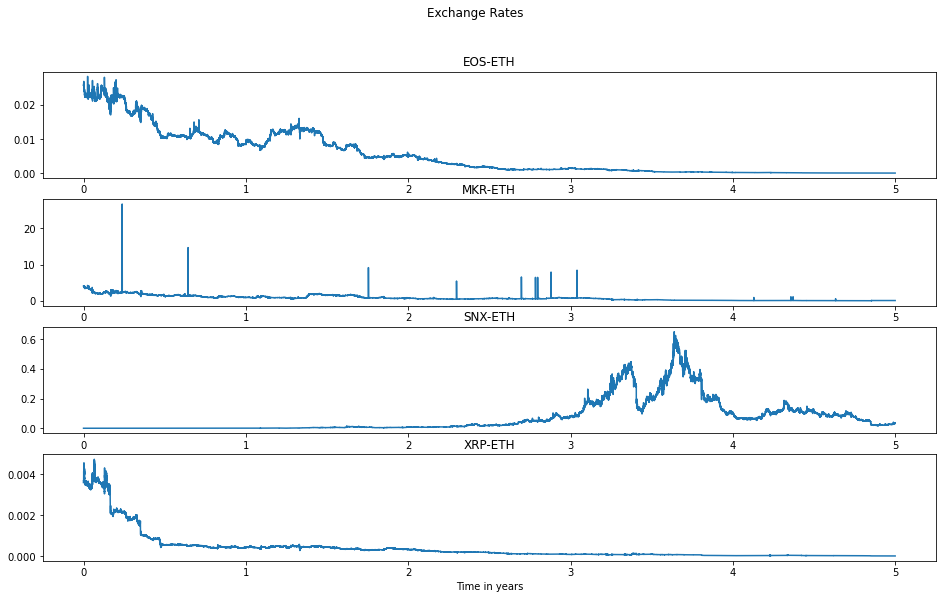

In [12]:
plot_multivariate_simulation(simulated_data=simulated_prices,
                             series_names=tickers, 
                             time_resolution=time_resolution, 
                             title='Exchange Rates')

In [13]:
# ticker_to_time_series_of_prices_map = \
#     construct_ticker_to_series_of_prices_map_from_simulated_prices(simulated_prices=simulated_prices, 
#                                                                    tickers=tickers_with_ovl)

In [14]:
# ticker_to_time_series_of_prices_map

In [15]:
# def construct_ticker_to_series_of_prices_map_from_historical_prices(
#         historical_price_df: pd.DataFrame, 
#         tickers: tp.Sequence[str], 
#         ovl_ticker: str, 
#         ovl_quote_ticker: str) -> tp.Dict[str, np.ndarray]:
    
#     result = {ovl_quote_ticker if ticker == ovl_ticker else ticker: historical_price_df.loc[:, ticker].values 
#               for ticker 
#               in tickers}
    
#     return result

In [16]:
# ticker_to_time_series_of_prices_map = \
#     construct_ticker_to_series_of_prices_map_from_historical_prices(
#         historical_price_df=closing_price_df, 
#         tickers=tickers, 
#         ovl_ticker=OVL_TICKER, 
#         ovl_quote_ticker=OVL_QUOTE_TICKER)

In [17]:
ticker_to_time_series_of_prices_map = \
    load_and_construct_ticker_to_series_of_prices_map_from_historical_prices(
        time_resolution=time_resolution,
        historical_data_source=historical_data_source,
        tickers=tickers,
        ovl_ticker=ovl_ticker,
        ovl_quote_ticker=ovl_quote_ticker)

In [18]:
ticker_to_time_series_of_prices_map.keys()

dict_keys(['EOS-ETH', 'MKR-ETH', 'OVL-ETH', 'XRP-ETH'])

# Load Resampled Data

# Construct Agent Based Monetary Model

In [19]:
# Constants
STEPS_MONTH = int((86400*30)/time_resolution.in_seconds)

total_supply = 100000  # OVL
# base_wealth = 0.0002*100000  # OVL
base_wealth = 0.001*100000  # OVL
base_market_fee = 0.0030
base_max_leverage = 10.0
base_liquidate_reward = 0.1
base_maintenance = 0.6
liquidity = 0.285*total_supply
time_liquidity_mine = STEPS_MONTH
treasury = 0.0
sampling_interval = int(3600/time_resolution.in_seconds)

# num_arbitrageurs = min(int(total_supply*0.1/base_wealth), 100)
num_arbitrageurs = min(int(total_supply*0.1/base_wealth), 50)
num_keepers = int(total_supply*0.005/base_wealth)
# num_traders = int(total_supply*0.005/base_wealth)
num_traders = 0
# num_holders = int(total_supply*0.5/base_wealth)
num_holders = 0
# num_snipers = min(int(total_supply*0.1/base_wealth), 100)
num_snipers = min(int(total_supply*0.1/base_wealth), 50)
# num_liquidators = int(total_supply*0.005/base_wealth)
num_liquidators = 4 * (len(tickers) + 1)
num_agents = num_arbitrageurs + num_keepers + \
    num_traders + num_holders + num_snipers + num_liquidators

DATA_COLLECTOR_NAME = 'data_collector'
data_collection_options = \
    DataCollectionOptions(compute_gini_coefficient=False,
                          compute_wealth=False,
                          compute_inventory_wealth=False, 
                          use_hdf5=True)

# For the first 30 days, emit until reach 100% of total supply; ONLY USE IN LIQUDITIY FOR NOW JUST AS TEST!
liquidity_supply_emission = [(0.51*total_supply/time_liquidity_mine)*i + 0.285*total_supply
                             for i
                             in range(time_liquidity_mine)]

monetary_model = \
    MonetaryModel(num_arbitrageurs=num_arbitrageurs, 
                  num_keepers=num_keepers, 
                  num_traders=num_traders, 
                  num_holders=num_holders, 
                  num_snipers=num_snipers, 
                  num_liquidators=num_liquidators, 
                  base_maintenance=base_maintenance, 
                  base_liquidate_reward=base_liquidate_reward, 
                  sims=ticker_to_time_series_of_prices_map, 
                  base_wealth=base_wealth, 
                  base_market_fee=base_market_fee, 
                  base_max_leverage=base_max_leverage, 
                  liquidity=liquidity, 
                  liquidity_supply_emission=liquidity_supply_emission, 
                  treasury=treasury, 
                  sampling_interval=sampling_interval, 
                  data_collection_options=data_collection_options, 
                  quote_ticker=quote_ticker, 
                  ovl_quote_ticker=ovl_quote_ticker, 
                  time_resolution=time_resolution, 
                  seed=0)

print("Model kwargs for initial conditions of sim:")
print(f"num_arbitrageurs = {num_arbitrageurs}")
print(f"num_snipers = {num_snipers}")
print(f"num_keepers = {num_keepers}")
print(f"num_traders = {num_traders}")
print(f"num_holders = {num_holders}")
print(f"num_liquidators = {num_liquidators}")
print(f"total number of agents = {num_agents}")
print(f"base_wealth = {base_wealth}")

Model kwargs for initial conditions of sim:
num_arbitrageurs = 50
num_snipers = 50
num_keepers = 5
num_traders = 0
num_holders = 0
num_liquidators = 20
total number of agents = 125
base_wealth = 100.0


Drastically reduced the number of traders and holders to bring down the memory requirement for storing agent wealth (with the original numbers it would have been 7500 agents total). This would exceed the 128GB mem of my machine with 200000 steps

# Run Simulation

In [20]:
# def run_model(number_of_steps_to_simulate: int, use_tqdm: bool = True):
#     run_range = range(number_of_steps_to_simulate + 1)
#     if use_tqdm:
#         run_range = tqdm(run_range)

#     try: 
#         for i in run_range:
#             monetary_model.step()
#     finally:
#         print('end')


In [21]:
# number_of_steps_to_simulate = 1000

In [22]:
number_of_steps_to_simulate

10080

In [23]:
monetary_model.run_steps(number_of_steps_to_simulate, use_tqdm=True)

100%|██████████| 10081/10081 [00:12<00:00, 779.68it/s] 


In [24]:
for market_name, market in monetary_model.fmarkets.items():
    print(f'open positions on {market_name} = {len(market.positions)}')

open positions on EOS-ETH = 2
open positions on MKR-ETH = 0
open positions on OVL-ETH = 25
open positions on XRP-ETH = 24


In [25]:
monetary_model.run_steps(500, use_tqdm=True)

100%|██████████| 501/501 [00:00<00:00, 1051.16it/s]


In [26]:
# hdf5_model_variables = monetary_model.data_collector.hdf5_file.get('MODEL_VARIABLES')

In [27]:
# [len(dataset) for name, dataset in hdf5_model_variables.items()]

In [28]:
# df = pd.DataFrame({name: np.array(dataset) for name, dataset in hdf5_model_variables.items()})
# df.tail()

In [29]:
# len(df)

# Extract Model Variables

Model Level Variables Collected During Simulation

In [30]:
monetary_model.data_collector.model_reporter_names

('d-EOS-ETH',
 'd-MKR-ETH',
 'd-OVL-ETH',
 'd-XRP-ETH',
 's-EOS-ETH',
 's-MKR-ETH',
 's-OVL-ETH',
 's-XRP-ETH',
 'f-EOS-ETH',
 'f-MKR-ETH',
 'f-OVL-ETH',
 'f-XRP-ETH',
 'Skew EOS-ETH',
 'Skew MKR-ETH',
 'Skew OVL-ETH',
 'Skew XRP-ETH',
 'Number of Open Positions on EOS-ETH',
 'Number of Open Positions on MKR-ETH',
 'Number of Open Positions on OVL-ETH',
 'Number of Open Positions on XRP-ETH',
 'Supply',
 'Treasury',
 'Liquidity')

In [31]:
# monetary_model.data_collector.hdf5_file['d-EOS-ETH']

In [32]:
# [dataset.shape for dataset in monetary_model.data_collector._model_reporter_collection.datasets]

In [33]:
model_vars_df = monetary_model.data_collector.get_model_vars_dataframe()
model_vars_df.head()

,d-EOS-ETH,d-MKR-ETH,d-OVL-ETH,d-XRP-ETH,s-EOS-ETH,s-MKR-ETH,s-OVL-ETH,s-XRP-ETH,f-EOS-ETH,f-MKR-ETH,...,Skew OVL-ETH,Skew XRP-ETH,Number of Open Positions on EOS-ETH,Number of Open Positions on MKR-ETH,Number of Open Positions on OVL-ETH,Number of Open Positions on XRP-ETH,Supply,Treasury,Liquidity,step
0,0.000000,0.000000,0.000000,-1.212483e-16,0.025823,4.100000,0.000636,0.003577,0.025823,4.100000,...,0.0,0.0,0,0,0,0,41000.0,0.0,28500.0,0
1,0.243522,0.178218,0.687998,2.034183e-01,0.020766,3.479833,0.000377,0.002972,0.025823,4.100000,...,0.0,0.0,0,0,0,0,41000.0,0.0,28500.0,1
2,0.199690,-0.117447,0.444773,5.772809e-01,0.021524,4.167512,0.000440,0.002268,0.025823,3.678050,...,0.0,0.0,0,1,0,0,40999.7,0.3,28500.0,2
3,0.199690,-0.010388,0.444773,5.772809e-01,0.021524,4.167512,0.000440,0.002268,0.025823,4.124221,...,0.0,0.0,0,2,0,0,40999.4,0.6,28500.0,3
4,0.199690,-0.010388,0.444773,5.772809e-01,0.021524,4.167512,0.000440,0.002268,0.025823,4.124221,...,0.0,0.0,0,2,0,0,40999.4,0.6,28500.0,4


In [34]:
len(model_vars_df)

10581

In [35]:
# model_vars_df.to_parquet('model_vars.parq')

In [36]:
model_vars_df.memory_usage(deep=True)

Index                                    128
d-EOS-ETH                              84648
d-MKR-ETH                              84648
d-OVL-ETH                              84648
d-XRP-ETH                              84648
s-EOS-ETH                              84648
s-MKR-ETH                              84648
s-OVL-ETH                              84648
s-XRP-ETH                              84648
f-EOS-ETH                              84648
f-MKR-ETH                              84648
f-OVL-ETH                              84648
f-XRP-ETH                              84648
Skew EOS-ETH                           84648
Skew MKR-ETH                           84648
Skew OVL-ETH                           84648
Skew XRP-ETH                           84648
Number of Open Positions on EOS-ETH    84648
Number of Open Positions on MKR-ETH    84648
Number of Open Positions on OVL-ETH    84648
Number of Open Positions on XRP-ETH    84648
Supply                                 84648
Treasury  

In [37]:
model_vars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10581 entries, 0 to 10580
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   d-EOS-ETH                            10581 non-null  float64
 1   d-MKR-ETH                            10581 non-null  float64
 2   d-OVL-ETH                            10581 non-null  float64
 3   d-XRP-ETH                            10581 non-null  float64
 4   s-EOS-ETH                            10581 non-null  float64
 5   s-MKR-ETH                            10581 non-null  float64
 6   s-OVL-ETH                            10581 non-null  float64
 7   s-XRP-ETH                            10581 non-null  float64
 8   f-EOS-ETH                            10581 non-null  float64
 9   f-MKR-ETH                            10581 non-null  float64
 10  f-OVL-ETH                            10581 non-null  float64
 11  f-XRP-ETH                   

In [38]:
# model_vars_df.head()

In [39]:
# fig = px.line(model_vars_df, y="Supply", title='OVL Supply')
# fig = px.line(model_vars_df, y="Treasury", title='Treasury')
# fig.show()


# Extract Wealth

In [40]:
# def convert_time_in_seconds_to_index(
#     time_resolution: TimeResolution, 
#     time_in_seconds: float):
#     return int(np.floor(time_in_seconds / time_resolution.in_seconds))

In [41]:
quarter_year_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=365.25 / 4.0 * 24 * 60 * 60)
quarter_year_index

131490

In [42]:
one_year_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=365.25 * 24 * 60 * 60)
one_year_index

525960

In [43]:
one_day_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=24 * 60 * 60)
one_day_index

1440

In [44]:
525960 / monetary_model.schedule.steps

49.703269703269704

In [45]:
monetary_model.schedule.steps / 4 / 60 / 24

1.8371527777777779

In [46]:
# type(monetary_model.data_collector._agent_records)

In [47]:
# def extract_agent_vars_for_time_step(monetary_model: MonetaryModel, time_step: int):
#     agent_vars_for_time_step = \
#         monetary_model.data_collector._agent_records[time_step]
#     column_names = ['time_step', 'agent_id'] + list(monetary_model.data_collector.agent_reporters.keys())
    
#     return pd.DataFrame(data=agent_vars_for_time_step, columns=column_names)

In [48]:
# column_names = ['time_step', 'agent_id'] + list(monetary_model.data_collector.agent_reporters.keys())
# column_names

In [49]:
# monetary_model.data_collector.agent_reporters

In [50]:
# df = \
#     extract_agent_vars_for_time_step(monetary_model, quarter_year_index)
# df.to_csv(f'agent_wealth_after_{quarter_year_index}_time_steps.csv')

In [51]:
# monetary_model.data_collector._agent_records[quarter_year_index]

# Extract Agent Variables

Agent Level Variables Collected During Simulation

In [52]:
monetary_model.data_collector.agent_reporter_names

('Wealth',)

Plot wealth distribution for each agent type

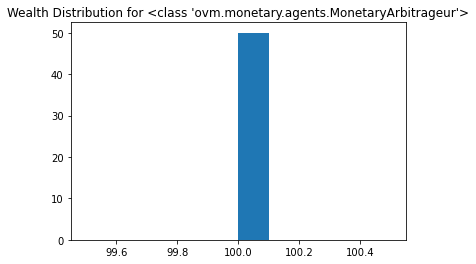

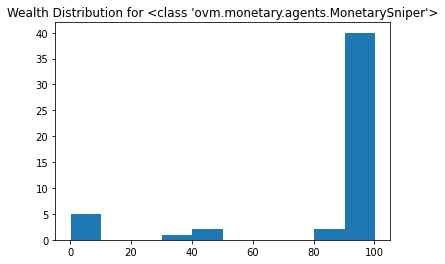

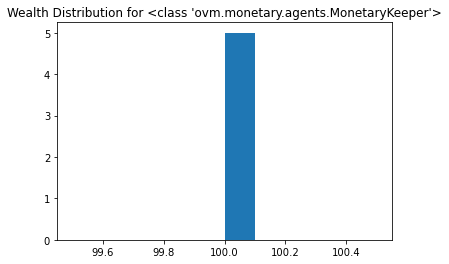

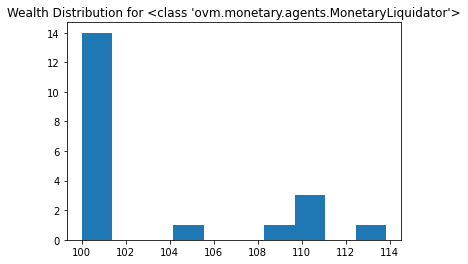

In [53]:
for agent_type in monetary_model.data_collector.agent_types:
    wealth_df_for_agent_type = \
        monetary_model.data_collector.get_agent_report_dataframe('Wealth', 
                                                                 use_agent_types_in_header=True, 
                                                                 agent_type=agent_type)
    plt.figure();
    plt.hist(wealth_df_for_agent_type.iloc[-1, :]);
    plt.title(f'Wealth Distribution for {agent_type}')

Wealth Dataframe for all Agent Types

In [54]:
wealth_df = \
    monetary_model.data_collector.get_agent_report_dataframe('Wealth', 
                                                             use_agent_types_in_header=True)

In [55]:
wealth_df.tail()

,MonetaryArbitrageur-0,MonetaryArbitrageur-1,MonetaryArbitrageur-2,MonetaryArbitrageur-3,MonetaryArbitrageur-4,MonetaryArbitrageur-5,MonetaryArbitrageur-6,MonetaryArbitrageur-7,MonetaryArbitrageur-8,MonetaryArbitrageur-9,...,MonetaryLiquidator-115,MonetaryLiquidator-116,MonetaryLiquidator-117,MonetaryLiquidator-118,MonetaryLiquidator-119,MonetaryLiquidator-120,MonetaryLiquidator-121,MonetaryLiquidator-122,MonetaryLiquidator-123,MonetaryLiquidator-124
10576,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,109.870326,100.0,100.0,100.691397,100.169897,109.82081,109.023208,113.844003,100.859051
10577,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,109.870326,100.0,100.0,100.691397,100.169897,109.82081,109.023208,113.844003,100.859051
10578,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,109.870326,100.0,100.0,100.691397,100.169897,109.82081,109.023208,113.844003,100.859051
10579,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,109.870326,100.0,100.0,100.691397,100.169897,109.82081,109.023208,113.844003,100.859051
10580,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,109.870326,100.0,100.0,100.691397,100.169897,109.82081,109.023208,113.844003,100.859051


Wealth Distribution for all Agent Types

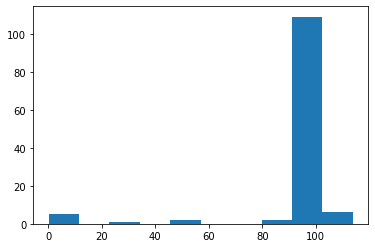

In [56]:
plt.hist(wealth_df.iloc[-1, :]);

In [57]:
# monetary_model.data_collector.__dict__

In [58]:
# agent_vars_df = monetary_model.data_collector.get_agent_vars_dataframe()
# print(len(agent_vars_df))

In [59]:
# agent_vars_df.to_csv(f'agent_vars.csv')

In [60]:
# agent_vars_df.to_parquet(f'agent_vars.parq')

In [61]:
# agent_vars_df.info()

In [62]:
# agent_vars_df.tail(300)

In [63]:
# agent_vars_df.loc[(699999, 1), :]
# df.loc[('cobra', 'mark i'), 'shield']

In [64]:
# agent_wealth = agent_vars_df.loc[pd.IndexSlice[one_year_index, :], :].values
# agent_wealth = agent_vars_df.loc[pd.IndexSlice[one_day_index, :], :].values

In [65]:
# agent_wealth.shape

In [66]:
# agent_wealth.sum()

In [67]:
# def arbitrageur_indices():
#     return 0, num_arbitrageurs


# def keeper_indices():
#     return num_arbitrageurs, num_arbitrageurs+num_keepers


# def sniper_indices():
#     begin_index = num_arbitrageurs + num_keepers + num_holders + num_traders
#     end_index = num_arbitrageurs + num_keepers + num_holders + num_traders + num_snipers
#     return begin_index, end_index

In [68]:
# sorted(agent_wealth[sniper_indices()[0]:sniper_indices()[1]])

In [69]:
# sorted(agent_wealth[keeper_indices()[0]:keeper_indices()[1]])

In [70]:
# sorted(agent_wealth[arbitrageur_indices()[0]:arbitrageur_indices()[1]])

In [71]:
# histogram = plt.hist(agent_vars_df.loc[pd.IndexSlice[one_day_index, :], :].values)

In [72]:
# sns.kdeplot(data=agent_wealth);

# Plot Results

## New Plots with 100 Arbitrageurs and 100 Snipers (no traders and no holders)

In [73]:
plot_time_scale = TimeScale.YEARS

### Set Plot Horizon in Seconds

In [74]:
plot_begin_years = 0.0
# plot_end_years = 5 * 365.25 * 24 * 60 * 60  # 5 years
# plot_end_years = 0.75 * 365.25 * 24 * 60 * 60  # 9 months
plot_end_years = 1 * 365.25 * 24 * 60 * 60  # 1 year
time_interval_to_plot_in_seconds = (plot_begin_years, plot_end_years)
time_interval_to_plot_in_seconds = None

### OVL Supply

In [75]:
def convert_time_index_to_time_in_seconds(
    time_step: int, 
    time_resolution: TimeResolution) -> float:
    return time_step * time_resolution.in_seconds

In [76]:
convert_time_index_to_time_in_seconds(
    model_vars_df.index.values[-1], 
    time_resolution=time_resolution)

634800

In [77]:
def express_time_index_in_time_scale(
    time_step: int, 
    time_resolution: TimeResolution, 
    time_scale: TimeScale) -> float:
    return time_step * time_resolution.in_seconds / time_scale.in_seconds()

In [78]:
express_time_index_in_time_scale(
    model_vars_df.index.values[-1], 
    time_resolution=time_resolution, 
    time_scale=TimeScale.YEARS)

0.02011559814434558

Initial OVL Supply

In [79]:
model_vars_df.loc[:, SUPPLY_LABEL].values[0]

41000.0

Final OVL Supply

In [80]:
model_vars_df.loc[:, SUPPLY_LABEL].values[-1]

39747.64970601458

OVL Growth in % over 1.93 years

In [81]:
(model_vars_df.loc[:, SUPPLY_LABEL].values[-1] / model_vars_df.loc[:, SUPPLY_LABEL].values[0] - 1) * 100

-3.054512912159568

Important: After the spike, the OVL supply does not go back to its initial level but increases from 41000 to to 54.6 million.

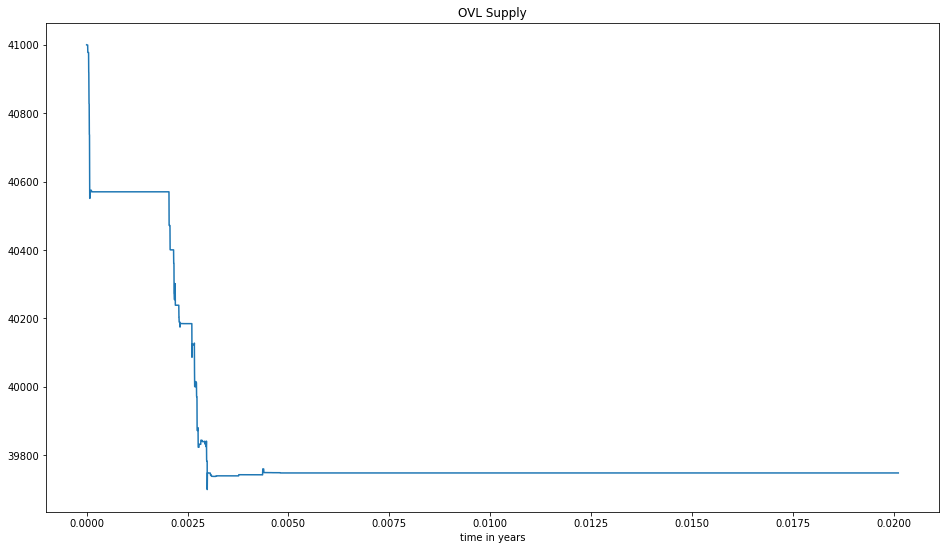

In [82]:
plot_supply(model_vars_df=model_vars_df, 
            plot_time_scale=plot_time_scale, 
            time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
            time_resolution=time_resolution, 
            data_interval=data_collection_options.data_collection_interval)

### Liquidity

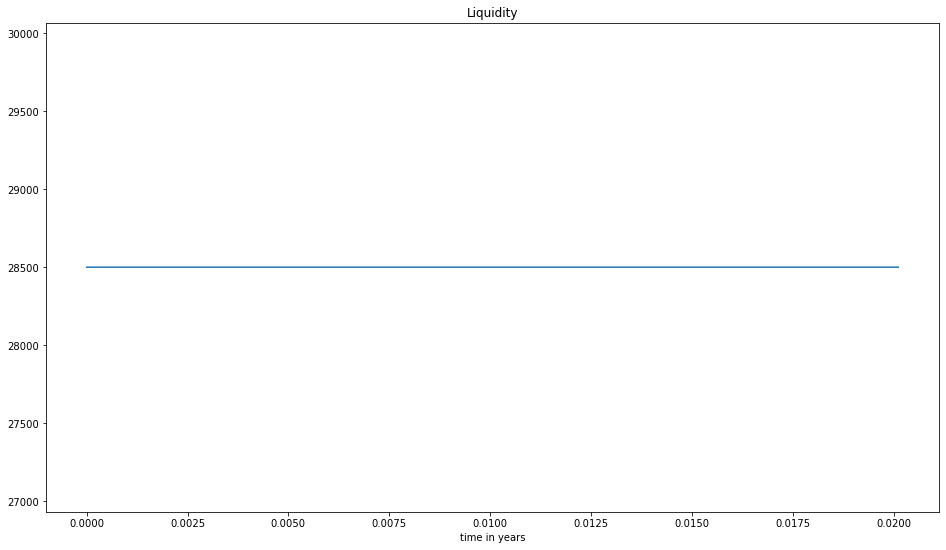

In [83]:
plot_liquidity(model_vars_df=model_vars_df,  
               plot_time_scale=plot_time_scale, 
               time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
               time_resolution=time_resolution, 
               data_interval=data_collection_options.data_collection_interval)

### Treasury

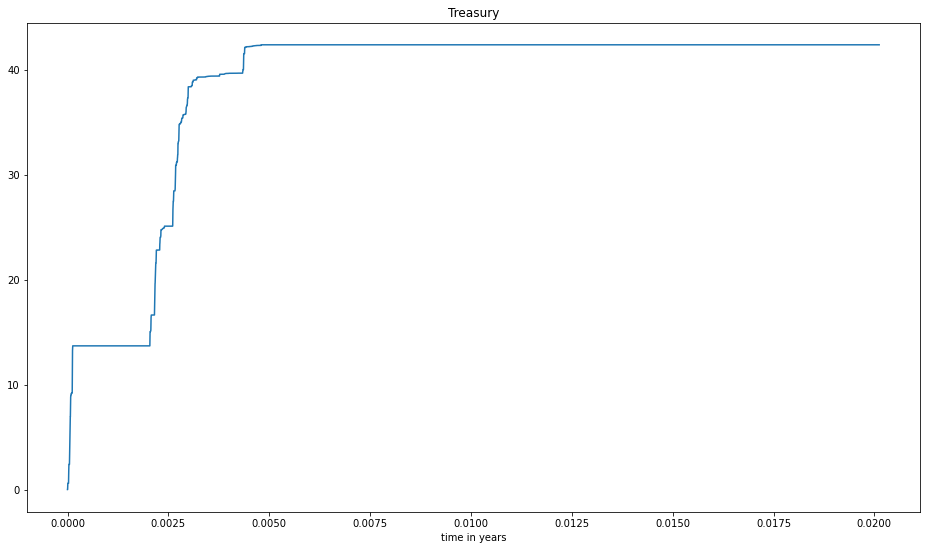

In [84]:
plot_treasury(model_vars_df=model_vars_df, 
              plot_time_scale=plot_time_scale, 
              time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
              time_resolution=time_resolution, 
              data_interval=data_collection_options.data_collection_interval)

### Price Deviations

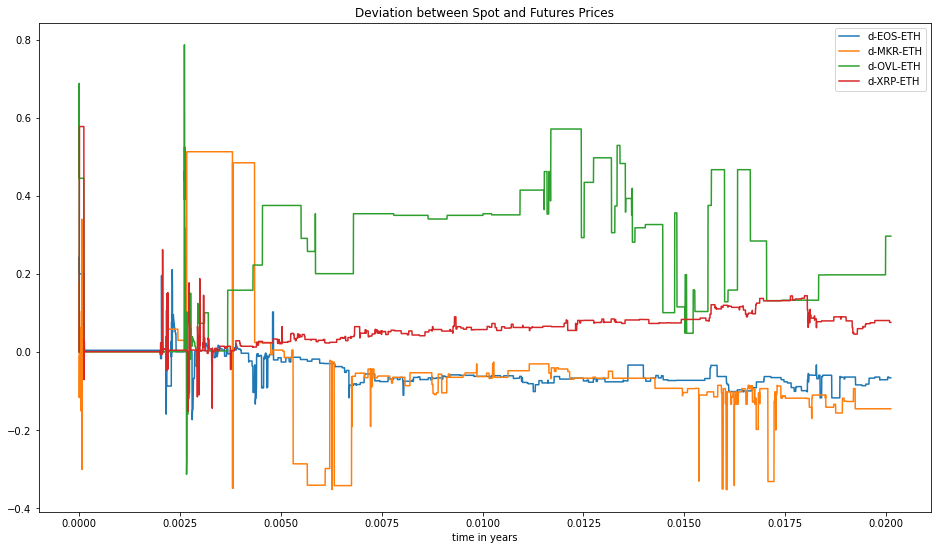

In [85]:
plot_price_deviations(
    model_vars_df=model_vars_df, 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

### Open Positions

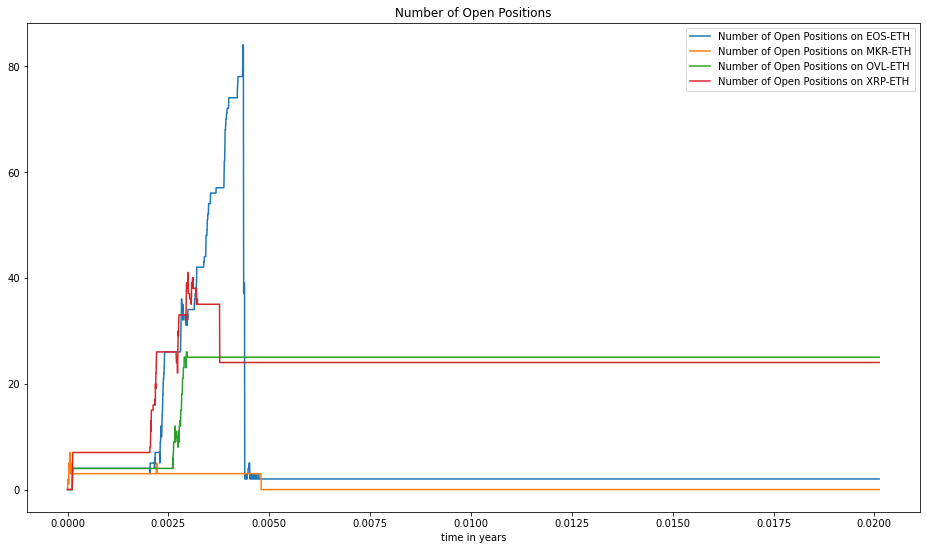

In [86]:
plot_open_positions(
    model_vars_df=model_vars_df, 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

### Skew

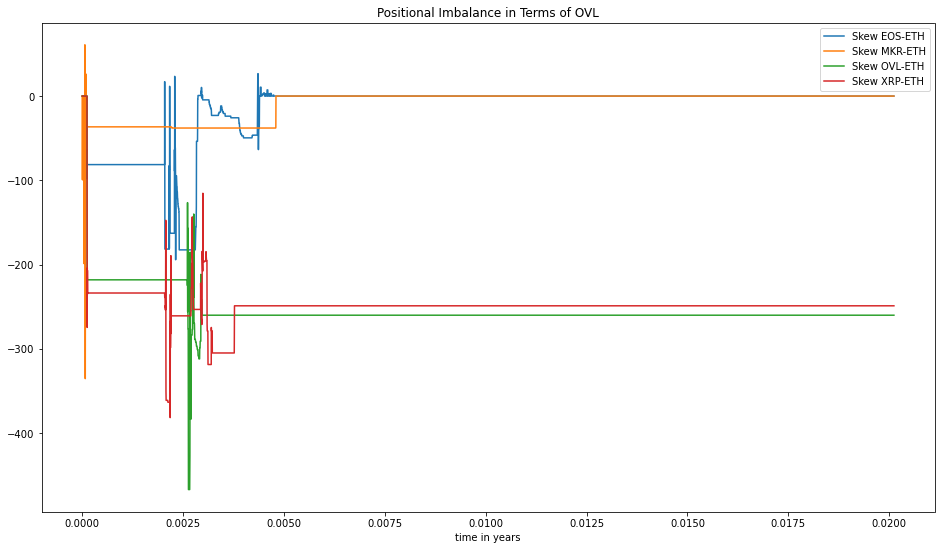

In [87]:
plot_skews(
    model_vars_df=model_vars_df, 
#     tickers=tickers_with_ovl[1:], 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

#### Correlation between Skew and Futures Price

In [88]:
for i, ticker in enumerate(tickers_with_ovl):
    if i > 0:
        break
    skew = model_vars_df.loc[:, skew_label(ticker)].values
    futures_price = model_vars_df.loc[:, futures_price_label(ticker)].values
    spot_price = model_vars_df.loc[:, spot_price_label(ticker)].values
    print(np.corrcoef(skew, futures_price))
    print(np.corrcoef(skew, spot_price))

[[1.         0.90558772]
 [0.90558772 1.        ]]
[[1.         0.82063151]
 [0.82063151 1.        ]]


### Cumulative Returns

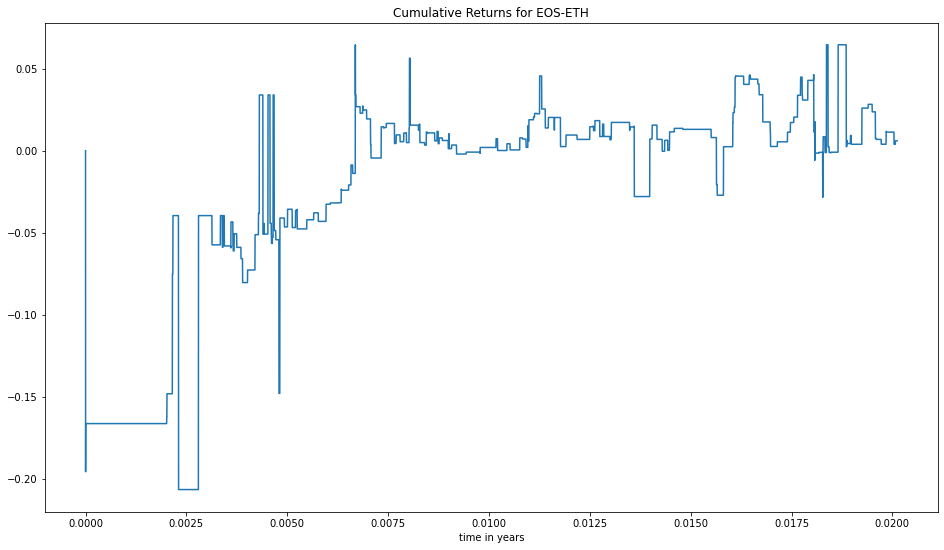

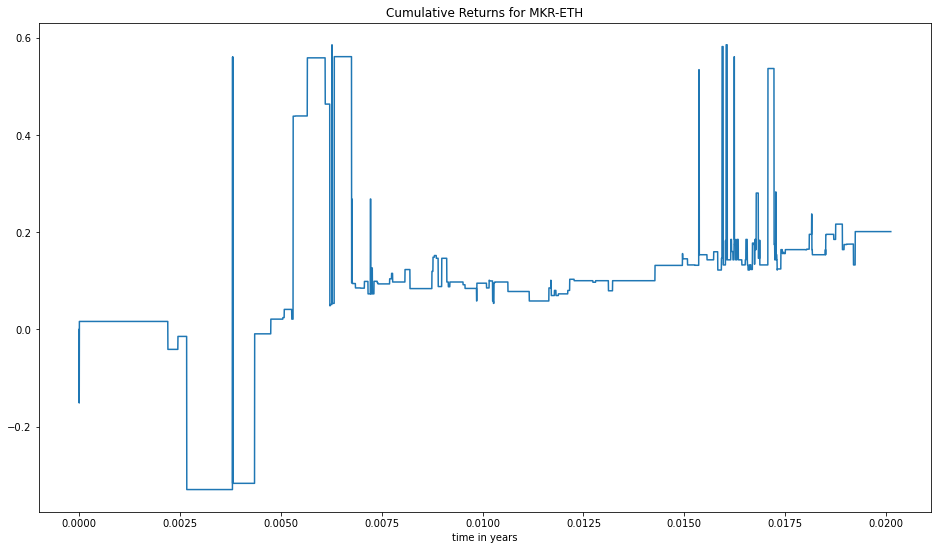

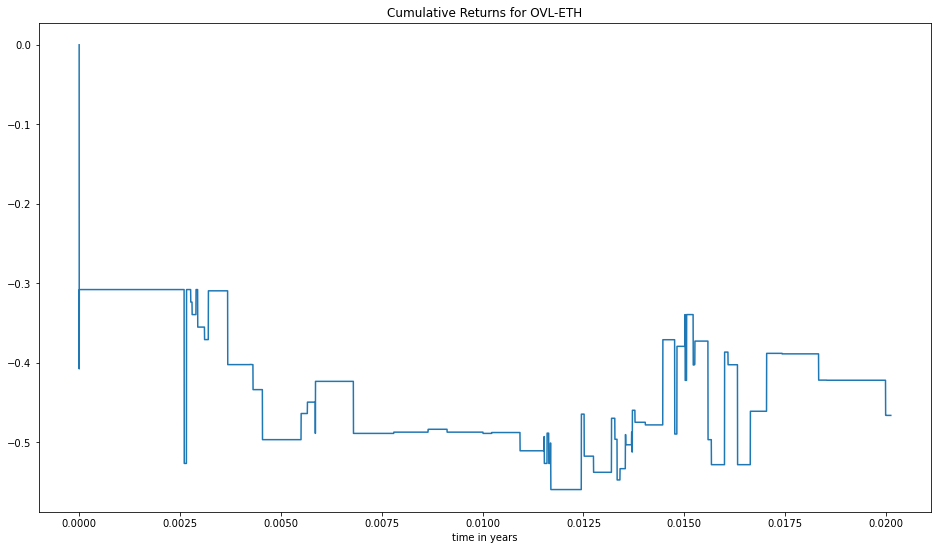

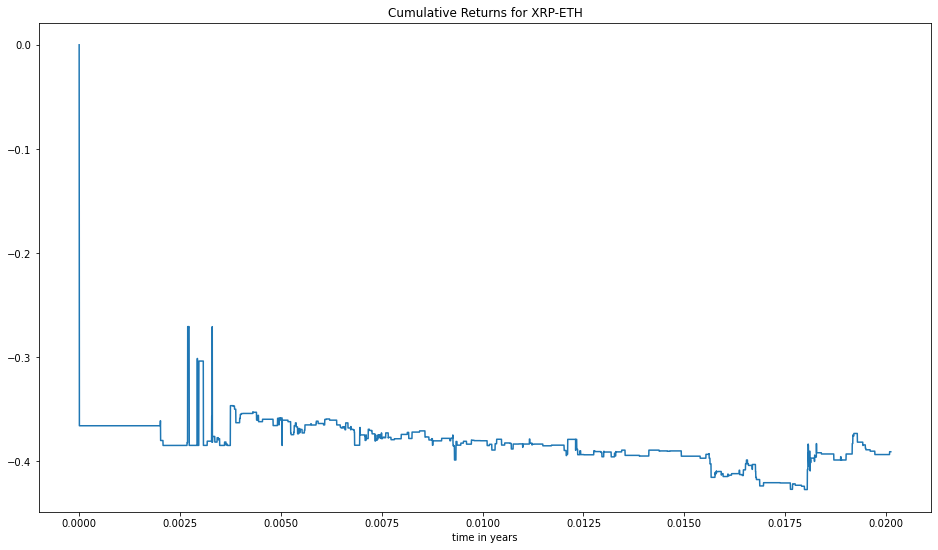

In [89]:
for i, ticker in enumerate(tickers_with_ovl):
    spot_prices_for_ticker = model_vars_df.loc[:, spot_price_label(ticker)].values
    cumulative_return_for_ticker = spot_prices_for_ticker / spot_prices_for_ticker[0] - 1.0
    
    plot_single_variable_over_time_from_numpy_array(
        array=cumulative_return_for_ticker, 
        plot_time_scale=plot_time_scale, 
        time_resolution=time_resolution, 
        time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
        data_interval=data_collection_options.data_collection_interval)
    
    plt.title(f'Cumulative Returns for {ticker}')

### Spot vs. Futures Prices

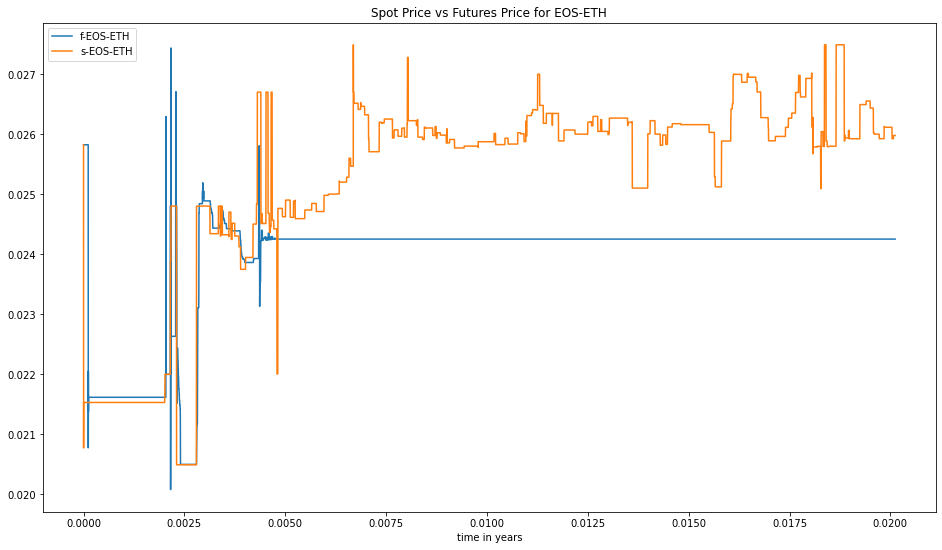

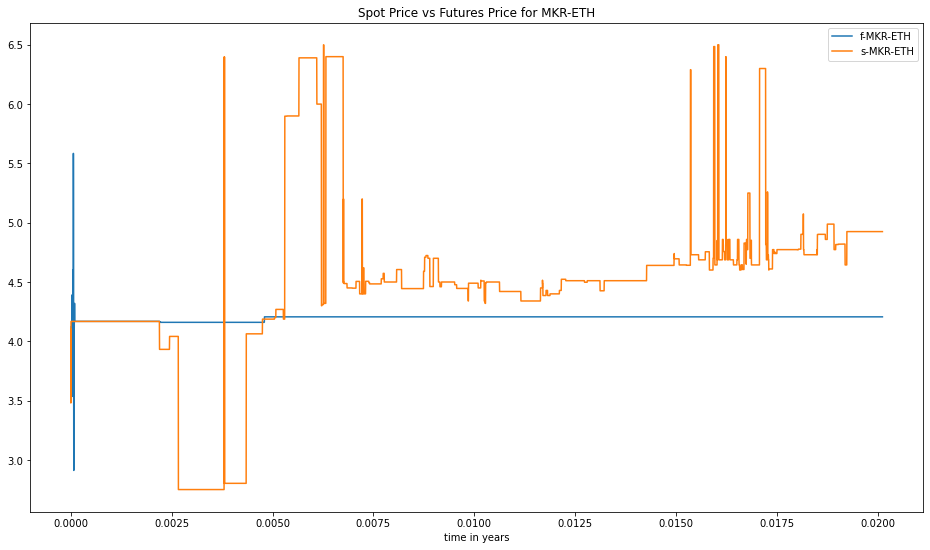

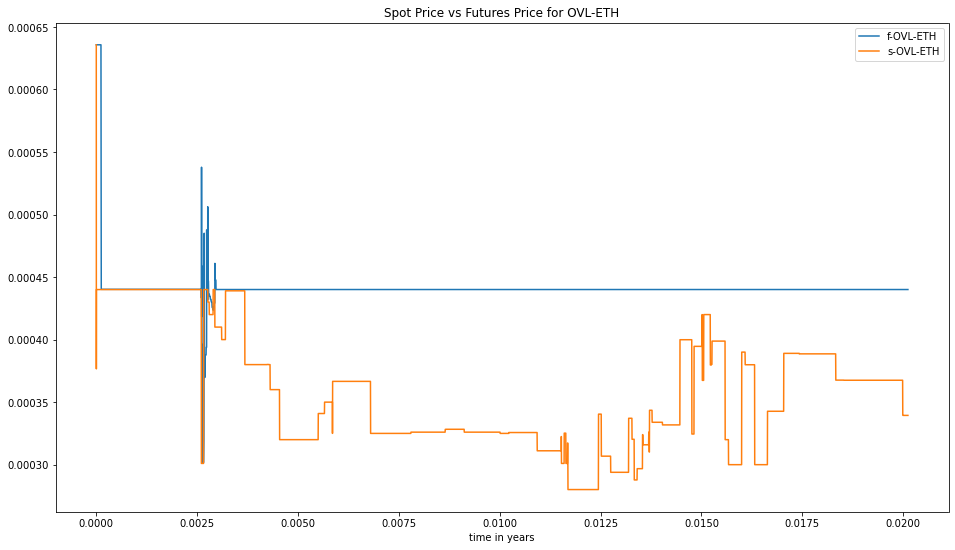

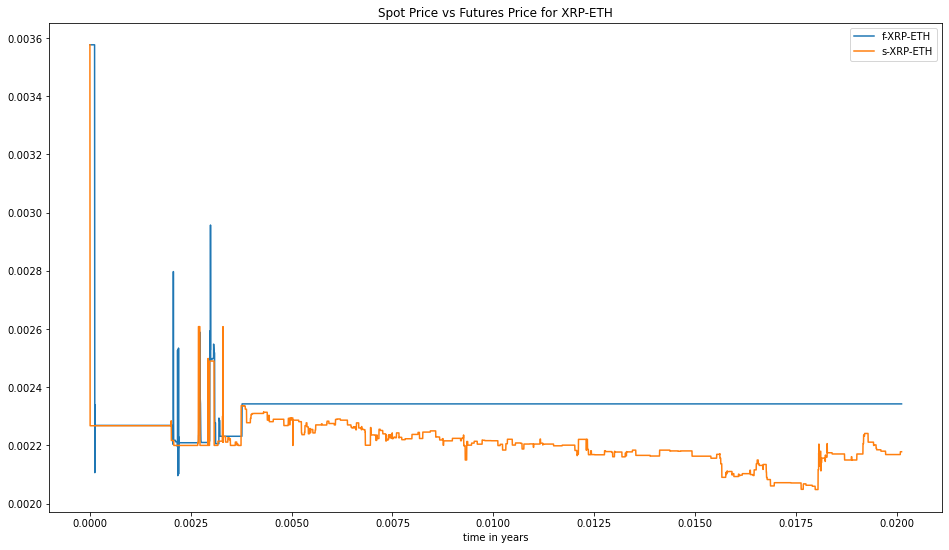

In [90]:
for i, ticker in enumerate(tickers_with_ovl):
    plot_spot_vs_futures_price(
        model_vars_df=model_vars_df, 
        ticker=ticker, 
        plot_time_scale=plot_time_scale, 
        time_resolution=time_resolution, 
        time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
        data_interval=data_collection_options.data_collection_interval)

In [91]:
# model_vars_df.columns

In [92]:
# tickers_with_ovl[0]

In [93]:
# def plot_cumulative_spot_returns(
#         model_vars_df: pd.DataFrame,
#         ticker: str,
#         plot_time_scale: TimeScale,
#         time_resolution: TimeResolution,
#         time_interval_to_plot_in_seconds:
#         tp.Optional[tp.Tuple[tp.Optional[float], tp.Optional[float]]] = None,
#         figure_size: tp.Tuple[float, float] = DEFAULT_FIGURE_SIZE,
#         data_interval: int = 1,
#         # relative: bool = False
# ):
#     column_name_to_label_map = \
#         {spot_price_label(ticker): spot_price_label(ticker)}

#     plot_multiple_variables_over_time(
#         model_vars_df=model_vars_df,
#         column_name_to_label_map=column_name_to_label_map,
#         plot_time_scale=plot_time_scale,
#         time_resolution=time_resolution,
#         time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds,
#         figure_size=figure_size,
#         data_interval=data_interval)

#     plt.legend();
#     plt.title(f'Spot Price vs Futures Price for {ticker}')


In [94]:
# %lprun \
#     -f compute_gini \
#     -f compute_price_difference \
#     -f compute_futures_price \
#     -f compute_spot_price \
#     -f compute_supply \
#     -f compute_liquidity \
#     -f compute_treasury \
#     -f compute_wealth_for_agent_type \
#     -f compute_inventory_wealth_for_agent \
#     -f compute_inventory_wealth_for_agent_type \
#     -f compute_positional_imbalance_by_market \
#     -f DataCollector.collect \
#     -f MonetaryAgent.step \
#     -f MonetaryArbitrageur._unwind_positions \
#     -f MonetaryArbitrageur._unwind_next_position \
#     -f MonetaryArbitrageur.trade \
#     -f MonetaryArbitrageur.step \
#     -f MonetaryKeeper.step \
#     -f MonetaryKeeper.distribute_funding \
#     -f MonetaryLiquidator.scope_liquidations \
#     -f MonetaryLiquidator.step \
#     -f MonetarySniper._get_unwind_amount \
#     -f MonetarySniper._unwind_positions \
#     -f MonetarySniper._get_filled_price \
#     -f MonetarySniper._get_size \
#     -f MonetarySniper._get_effective_edge \
#     -f MonetarySniper.trade \
#     -f MonetaryFMarket.build \
#     -f MonetaryFMarket.unwind \
#     -f MonetaryFMarket._swap \
#     -f MonetaryFMarket.slippage \
#     -f MonetaryFMarket.fund \
#     -f MonetaryFMarket.funding \
#     -f MonetaryFMarket.liquidatable \
#     -f MonetaryFMarket.liquidate \
#     -f MonetaryModel.step \
#     run_model(number_of_steps_to_simulate)

In [95]:
# plt.close('all')